# GRU Model

In [12]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'lib'))

from train import get_features

## Load Config

In [13]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel")

options = Option(
    inputModel = '../example-keras-model-files/KERAS_gru_model_weights.h5',
    inputFile = '../data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = '../example-keras-model-files/train_config_gru.yml',
    jsonModel = '../example-keras-model-files/KERAS_gru_model.json'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)

yamlConfig

Loading configuration from ../example-keras-model-files/train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

## Load Model

In [14]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

#model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1620      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________


## Evaluate Example Model

In [15]:
#X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig, test_size=0.99)

In [16]:
def makeRoc(features_val, labels, labels_val, model, outputDir, outputFile=''):
    if 'j_index' in labels: labels.remove('j_index')
    predict_test = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    plt.semilogy()
    plt.ylabel("Background Efficiency")
    plt.xlabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'GRU ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig('%s/GRU_ROC%s.pdf'%(outputDir, outputFile))
    return predict_test

In [17]:
#y_pred = makeRoc(X_test, labels, y_test, model, os.curdir, '_example')

## Retraining Model

In [18]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig, test_size=0.2)

Shape:
(5131613,)
   j1_ptrel  j1_etarot  j1_phirot   j1_erel  j1_deltaR  j1_pdgid  j_index
0  0.386118   0.000000   0.000000  0.382772   0.011056     130.0   101333
1  0.107734  -0.009859   0.007236  0.105703   0.023104     211.0   101333
2  0.094731   0.004508  -0.002759  0.094339   0.006306     321.0   101333
3  0.042086   0.028567  -0.014909  0.042913   0.022473     211.0   101333
4  0.039412  -0.018020  -0.003745  0.038547   0.025492    -211.0   101333
   j_g  j_q  j_w  j_z  j_t  j_index
0    1    0    0    0    0   101333
1    1    0    0    0    0   101333
2    1    0    0    0    0   101333
3    1    0    0    0    0   101333
4    1    0    0    0    0   101333
(98769, 5)


In [19]:
from keras.optimizers import Adam, Nadam
from callbacks import all_callbacks

In [20]:
adam = Adam(lr=yamlConfig['L1Reg'])
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

callbacks=all_callbacks(stop_patience=1000, 
                            lr_factor=0.5,
                            lr_patience=10,
                            lr_epsilon=0.000001, 
                            lr_cooldown=2, 
                            lr_minimum=0.0000001,
                            outputDir=os.curdir + '\\training_callbacks')

history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 400,
                      validation_split = 0.25, shuffle = True, callbacks = callbacks.callbacks)

 [==============================] - 1s 18us/step - loss: 0.8949 - accuracy: 0.7053 - val_loss: 0.8860 - val_accuracy: 0.7087

***callbacks***
saving losses to .\training_callbacks\losses.log

Epoch 00366: val_loss did not improve from 0.88581

Epoch 00366: val_loss did not improve from 0.88581

Epoch 00366: saving model to .\training_callbacks\KERAS_check_model_last.h5

Epoch 00366: saving model to .\training_callbacks\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 367/400
59261/59261 [==============================] - 1s 21us/step - loss: 0.8943 - accuracy: 0.7055 - val_loss: 0.8858 - val_accuracy: 0.7092

***callbacks***
saving losses to .\training_callbacks\losses.log

Epoch 00367: val_loss improved from 0.88581 to 0.88580, saving model to .\training_callbacks\KERAS_check_best_model.h5

Epoch 00367: val_loss improved from 0.88581 to 0.88580, saving model to .\training_callbacks\KERAS_check_best_model_weights.h5

Epoch 00367: saving model to .\training_callbacks\KERAS_

## Evaluating Retrained Model

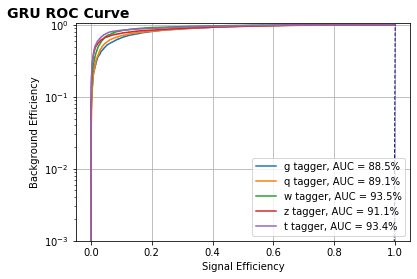

In [21]:
y_pred = makeRoc(X_test, labels, y_test, model, os.curdir, '_trained4')

In [22]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

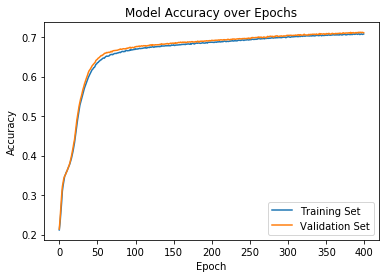

In [23]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set','Validation Set'])
plt.savefig('%s/Accuracy4.pdf'%(os.curdir))
plt.show()

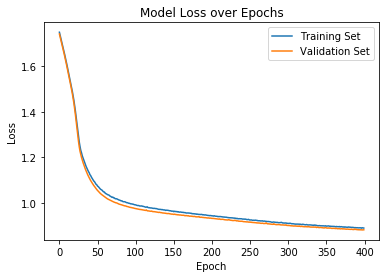

In [24]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set','Validation Set'])
plt.savefig('%s/Loss4.pdf'%(os.curdir))
plt.show()

In [25]:
model.save_weights("gru_model_trained4_400_weights.h5")